In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
from astropy.io import fits

In [6]:
from __future__ import unicode_literals

figsize(8,6)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [7]:
rc = 107.2
dc = 5.2
d2r = np.pi / 180.

In [8]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [9]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [10]:
def calculate_sflux_gal(bank='A', session='5', pixbeam=1., smth=None, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    #beamarea = np.pi / (4. * np.log(2)) * beam**2
    #pixelarea = pixbeam**2
    beamarea = np.pi / (4. * np.log(2)) * (beam / 60. * d2r)**2
    units = 1. / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    varmap, varhits, rabins, decbins = naive_map(calibrated*calibrated, ras, decs, nrapix, ndecpix) 
    varmask = hits == 0
    varsignal = np.zeros_like(varmap)
    varsignal[~varmask] = varmap[~varmask] / varhits[~varmask] * units * units
    varsignal[~varmask] -= signal[~varmask]**2
    #varsignal[varmask] = np.nan
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= (45./60.)
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0

    annulus = (radius >= (60./60.) ) & (radius <= (80./60.))
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0

    sigma = beam / pixbeam / (2. * np.sqrt(2. * np.log(2)))
    signal = gaussian_filter(signal, sigma)
    shits = gaussian_filter(hits, sigma)
    svar = gaussian_filter(varsignal, sigma)
    mask = shits < 1
    
    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
     
    if smth is not None:
        smth = np.sqrt(smth**2 - beam**2)
        sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        signal = gaussian_filter(signal, sigma, mode='mirror')
        shits = gaussian_filter(hits, sigma)
        #mask = shits < 1
        
    signal -= np.nanmedian(signal[outerregion])
    signal[mask] = np.nan
    shits[mask] = np.nan
    svar[mask] = np.nan
    
    rdata = signal[innerregion]
    adata = signal[outerregion]
    flux = np.sum(rdata - np.median(adata))
    rms = np.std(adata) * np.sqrt(len(rdata) + pi/2. * float(len(rdata)**2) / len(adata))
    
    return signal, rabinsc, decbinsc, shits, svar, mask, hits, innerregion

In [39]:
signal, rabins, decbins, shits, svar, mask, hits, inner = calculate_sflux_gal('C', session='5', removeplane=True, smth=None)

In [40]:
rmsmap = np.zeros_like(svar)
rmsmap[~mask] = np.sqrt(svar[~mask])
rmsmap[mask] = np.nan

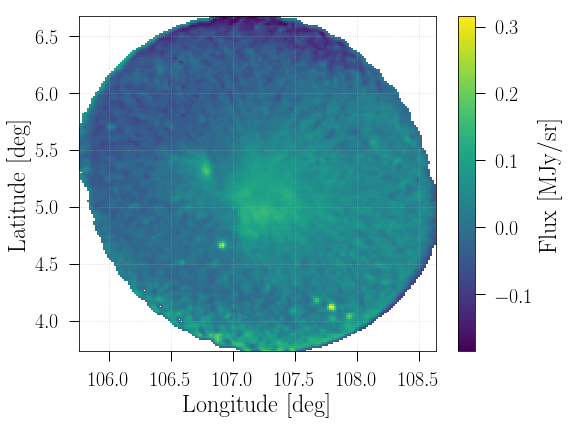

In [41]:
figure()
pc = pcolormesh(rabins, decbins, signal * 1e-6)
#clim(-10, 11)
cb = colorbar()
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
cb.set_label('$\mathrm{Flux\ [MJy / sr]}$')
grid(ls='dotted', alpha=0.5)
#xlim(105.75, 108.63)
#ylim(3.73, 6.67)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()

In [42]:
mask = np.isnan(shits)
weightmap = rmsmap / np.sqrt(shits - 1)
weightmap[mask] = np.nan

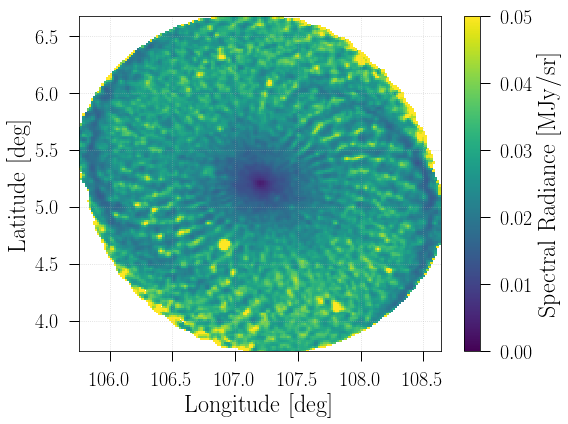

In [43]:
figure()
pc = pcolormesh(rabins, decbins, weightmap * 1e-6, rasterized=True)
clim(0, 0.05)
cb = colorbar()
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
cb.set_label('$\mathrm{Spectral\ Radiance\ [MJy / sr]}$')
grid(ls='dotted', alpha=0.5)
#xlim(105.75, 108.63)
#ylim(3.73, 6.67)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
savefig('noisemapC.pdf', format='pdf', dpi=300)

In [18]:
print np.sqrt(np.nansum(rmsmap[inner]**2) / np.sum(inner)) * 1e-6

0.0482249029819


In [19]:
np.sqrt(np.nansum(weightmap[inner]**2)) * 1e-6

1.0879251339296048

In [20]:
np.sqrt(0.0672948359813**2 + 0.0482249029819**2)

0.082790314755795777

In [21]:
np.sqrt(0.082790314755795777**2 + 1.81**2)

1.8118924460953425

In [22]:
print np.sqrt(np.nansum(rmsmap[inner]**2) / np.sum(inner)) * 1e-6

0.0482249029819


In [23]:
np.sqrt(0.0810618422286**2 + 0.061149808759**2)

0.10153975269202063

In [24]:
np.sqrt(0.10153975269202063**2 + 1.75**2)

1.7529433309085485

In [25]:
print np.sqrt(np.nansum(rmsmap[inner]**2) / np.sum(inner)) * 1e-6

0.0482249029819


In [26]:
np.sqrt(0.123176390199**2 + 0.0853045331081**2)

0.14983085954250958

In [27]:
np.sqrt(0.14983085954250958**2 + 1.75**2)

1.756402370321575

In [28]:
print np.sqrt(np.nansum(rmsmap[inner]**2) / np.sum(inner)) * 1e-6

0.0482249029819


In [29]:
np.sqrt(0.325624019512**2 + 0.693483132709**2)

0.76612652834570338

In [30]:
np.sqrt(0.76612652834570338**2 + 3.24**2)

3.3293467613685181

In [59]:
mask = np.isnan(shits)
s2n = np.abs(signal) / weightmap
s2n[mask] = np.nan

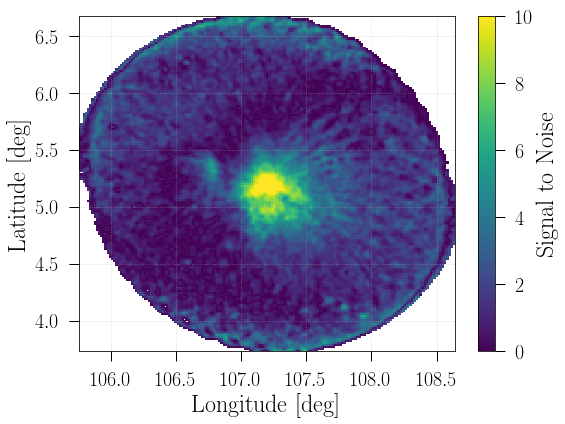

In [60]:
figure()
pc = pcolormesh(rabins, decbins, s2n, rasterized=True)
clim(0, 10)
cb = colorbar()
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
cb.set_label('$\mathrm{Signal\ to\ Noise}$')
grid(ls='dotted', alpha=0.5)
#xlim(105.75, 108.63)
#ylim(3.73, 6.67)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
#savefig('noisemapC.pdf', format='pdf', dpi=300)

In [61]:
s2nflat = s2n[~mask].flatten()

In [62]:
s2nin = s2n[inner].flatten()

In [39]:
np.max(s2nflat)

39.857790677098095

In [42]:
np.median(s2nin)

3.2204123614930777

In [52]:
np.max(s2nflat)

35.724765509683372

In [53]:
np.median(s2nin)

2.6465648490268299

In [63]:
np.max(s2nflat)

26.381109212659673

In [64]:
np.median(s2nin)

1.941268808525596

In [27]:
np.median(s2nflat)

1.5216679047008899

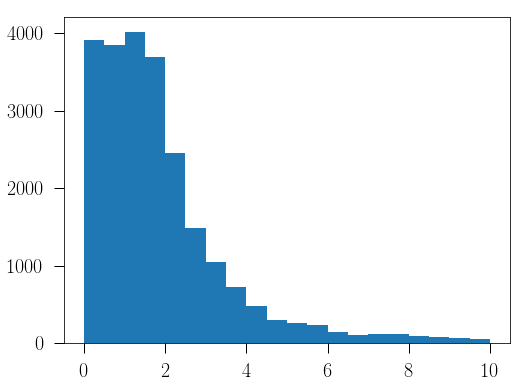

In [28]:
smask = s2nflat < 10
hist(s2nflat[smask], bins=20);

In [58]:
weightsflat = weightmap[~mask].flatten() * 1e-6
print 'A', np.nanmedian(weightsflat)

A 0.0152321013015


In [64]:
weightsflat = weightmap[~mask].flatten() * 1e-6
print 'B', np.nanmedian(weightsflat)

B 0.0196540495402


In [70]:
weightsflat = weightmap[~mask].flatten() * 1e-6
print 'C', np.nanmedian(weightsflat)

C 0.0271614272017
